# Mount at drive & libraries

In [1]:
# Mount at drive
from google.colab import drive
drive.mount('/gdrive')

# Where I fix my cd
print("\n--> CURRENT DIRECTORY:")
%cd /gdrive/MyDrive/NECST

Mounted at /gdrive

--> CURRENT DIRECTORY:
/gdrive/MyDrive/NECST


In [2]:
# Useful libraries
import keras 
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from tqdm import tqdm

# Libraries suggested by Kits19 challenge repo
from starter_code.utils import load_case
from starter_code.visualize import visualize

# Brief visualization

In [3]:
# path to my data 
# ATTENZION!!! In order to get results, this path must be modified 
data_path = "/gdrive/MyDrive/NECST/data"

# content of "data_path"
print(f'contenuto di DATA_DIR ({str(data_path)}): {os.listdir(data_path)}')

contenuto di DATA_DIR (/gdrive/MyDrive/NECST/data): ['kits.json', 'LICENSE', 'case_00208', 'case_00170', 'case_00279', 'case_00014', 'case_00193', 'case_00093', 'case_00255', 'case_00290', 'case_00035', 'case_00270', 'case_00249', 'case_00098', 'case_00169', 'case_00259', 'case_00183', 'case_00131', 'case_00177', 'case_00103', 'case_00121', 'case_00076', 'case_00090', 'case_00063', 'case_00056', 'case_00166', 'case_00298', 'case_00057', 'case_00179', 'case_00091', 'case_00096', 'case_00074', 'case_00250', 'case_00109', 'case_00034', 'case_00005', 'case_00082', 'case_00011', 'case_00281', 'case_00252', 'case_00291', 'case_00263', 'case_00032', 'case_00075', 'case_00246', 'case_00289', 'case_00233', 'case_00122', 'case_00060', 'case_00001', 'case_00231', 'case_00133', 'case_00113', 'case_00296', 'case_00140', 'case_00219', 'case_00023', 'case_00190', 'case_00175', 'case_00043', 'case_00189', 'case_00266', 'case_00097', 'case_00207', 'case_00149', 'case_00000', 'case_00235', 'case_00118',

Data (`kits19/data`) structure:

```
data
├── case_00000
|   ├── imaging.nii.gz       ──> CT image (Nifty1Image, dtype=np.float32, range=[-2048.0, 2048.0], size=(*, 512, 512))
|   └── segmentation.nii.gz  ──> segment. (Nifty1Image, dtype=np.uint8,   range={0,1,2},           size=(*, 512, 512))
├── case_00001
|   ├── imaging.nii.gz
|   └── segmentation.nii.gz
...
├── case_00209
|   ├── imaging.nii.gz
|   └── segmentation.nii.gz
└── kits.json

```

In [4]:
# I choose one (random) case in order to load and extract its volume & segmentation
random_case = "case_00123"
volume, segmentation = load_case(random_case)

# a brief analysis of volume & segmentation structure
print("Volume:")
print("SHAPE: ", volume.shape)
print("TYPE:", volume.get_data_dtype())

print("\nSegmentation:")
print("SHAPE: ",segmentation.shape)
print("TYPE:",segmentation.get_data_dtype())

Volume:
SHAPE:  (389, 512, 512)
TYPE: float64

Segmentation:
SHAPE:  (389, 512, 512)
TYPE: uint8


Text(0.5, 1.0, 'Segmentation of case 123, slice 128')

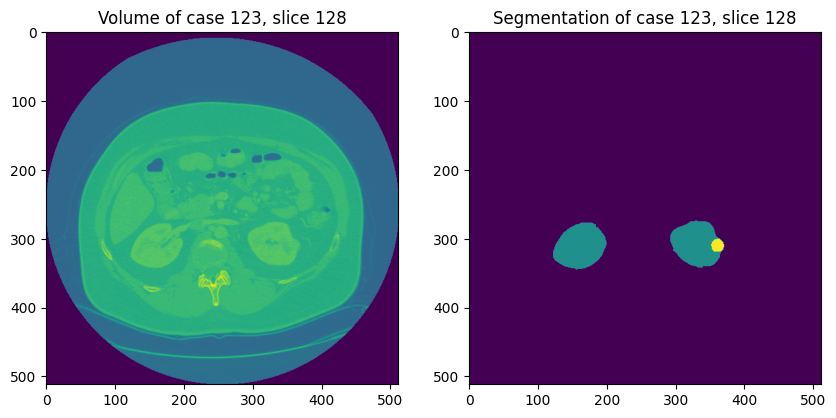

In [5]:
volume_img = volume.get_fdata()
segmentation_img = segmentation.get_fdata()
slice = 128

fig, ax = plt.subplots(1, 2,figsize=(10, 10))

ax[0].imshow(volume_img[slice, :, :])
ax[0].set_title("Volume of case " + str(random_case)[7:10] + ", slice " + f'{slice}')

ax[1].imshow(segmentation_img[slice, :, :])
ax[1].set_title("Segmentation of case " + str(random_case)[7:10] + ", slice " + f'{slice}')

# Dataset


-   **Loading, extraction of volumes and segmentations & preprocessing**




In [6]:
# --> getVolumes: Function that extracts and resizes specific volume slices 
#                and stores them in a list of images that is returned as output.
def getVolumes(first, last):

    volumes = []  
    for out in range(first, last):
        # loading of volume and conversion to array with "get_fdata()"
        img = nib.load(data_path + f'/case_{out:05d}' + f'/imaging.nii.gz').get_fdata()
        print("- Loading volume of", f'case_{out:05d}')
        # NORMALIZATION
        img = (img - img.min()) / (max((img.max() - img.min()), 1e-3))
        # RESIZE in order to have all volumes with same size
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH))

        count=1 
        for j in range(0,int(img.shape[0]),12):
            volumes.append(resize(img[j,:,:], (IMG_HEIGHT, IMG_WIDTH)))
            count+=1

    return volumes

In [7]:
# --> getSegmentations: Function that extracts and resizes specific volume slices 
#                       and stores them in a list of images that is returned as output.
def getSegmentations(first, last):

    segmentations = []
    for out in range(first, last):
        # loading of segmentation and conversion to array with "get_fdata()"
        img = nib.load(data_path + f'/case_{out:05d}' + f'/segmentation.nii.gz').get_fdata()
        print("- Loading segmentation of", f'case_{out:05d}')
        # NORMALIZATION
        img = (img - img.min()) / (max((img.max() - img.min()), 1e-3))
        # RESIZE in order to have all segmentations with same size
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH))
        
        count=1 
        for j in range(0,int(img.shape[0]),12):
            segmentations.append(resize(img[j,:,:], (IMG_HEIGHT, IMG_WIDTH)))
            count+=1

    return segmentations

-   **Splitting in training & validation**

In [8]:
# ---> Splitting in training & validation, 
#      volumes compose data while segmentations compose labels

# desired volumes and segmentations size set during resizing
IMG_WIDTH = 256
IMG_HEIGHT = 256 
# IMG_CHANNELS = 1 <--> GREYSCALE IMAGES
IMG_CHANNELS = 1

# due to my limited upload possibilities on google drive, 
# the dataset I work with consists of only a part of complete dataset
start_train = 55
end_training = 155
start_test = 155
end_test = 205

print("SPLITTING")
print("Training phase:")
print("--> Data: ")
train_data = np.array(getVolumes(start_train, end_training))
print("--> Labels: ")
train_label = np.array(getSegmentations(start_train, end_training))

print("Validation phase:")
print("--> Data: ")
test_data = np.array(getVolumes(start_test, end_test))
print("--> Labels: ")
test_label = np.array(getSegmentations(start_test, end_test))

SPLITTING
Training phase:
--> Data: 
- Loading volume of case_00055
- Loading volume of case_00056
- Loading volume of case_00057
- Loading volume of case_00058
- Loading volume of case_00059
- Loading volume of case_00060
- Loading volume of case_00061
- Loading volume of case_00062
- Loading volume of case_00063
- Loading volume of case_00064
- Loading volume of case_00065
- Loading volume of case_00066
- Loading volume of case_00067
- Loading volume of case_00068
- Loading volume of case_00069
- Loading volume of case_00070
- Loading volume of case_00071
- Loading volume of case_00072
- Loading volume of case_00073
- Loading volume of case_00074
- Loading volume of case_00075
- Loading volume of case_00076
- Loading volume of case_00077
- Loading volume of case_00078
- Loading volume of case_00079
- Loading volume of case_00080
- Loading volume of case_00081
- Loading volume of case_00082
- Loading volume of case_00083
- Loading volume of case_00084
- Loading volume of case_00085
- 

# Model



*   **Network definition**



In [9]:
def uNet_kits19():

    # input layer with fixed size
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # NORMALIZATION of inputs
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # CONTRACTION PATH: reduces image size and captures relevant features

    # 256x256 - ReLu introduces non-linearity
    c1 = tf.keras.layers.Conv2D(
        16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(256, 256, 1))(s)
    # DROPOUT in order to reduce overfitting
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c1)

    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    # 128x128
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p1)

    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c2)

    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    # 64x64
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c3)

    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    # 32x32
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c4)

    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    # 16x16
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c5)

    # EXPANSIVE PATH: reconstructs the segmented image at a higher resolution using the extracted features.

    # Conv2DTranspose restore the spatial dimension of the image to a higher resolution
    u6 = tf.keras.layers.Conv2DTranspose(
        128, (2, 2), strides=(2, 2), padding='same')(c5)
    # 32x32
    # CONCATENATE combine the features extracted from the contraction and expansion paths
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c6)

    # 64x64
    u7 = tf.keras.layers.Conv2DTranspose(
        64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c7)

    # 128x128
    u8 = tf.keras.layers.Conv2DTranspose(
        32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c8)

    # 256x256
    u9 = tf.keras.layers.Conv2DTranspose(
        16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model



*   **Model building**


In [10]:
print('\n Building the model...')

# outputs obtained by my model
model = uNet_kits19()

adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
# LOSS FUNCTION = CATEGORICAL CROSSENTROPY --> used for multiclass segmentation problems
model.compile(optimizer=adam, loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


 Building the model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                      



*   **Model fitting**


In [11]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'final_model.h5', verbose=1, save_best_only=True
    )

# EARLY STOPPING stops training if loss on validation stops improving for a certain number of epochs
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

results = model.fit(train_data, train_label, validation_split=0.1,
                    batch_size=25, epochs=25, callbacks=callbacks)
model.save("/gdrive/MyDrive/NECST/results")

Epoch 1/25
80/80 [==============================] - 50s 326ms/step - loss: 8.9528 - accuracy: 0.3974 - val_loss: 9.3506 - val_accuracy: 0.4078
Epoch 2/25
80/80 [==============================] - 21s 263ms/step - loss: 8.9526 - accuracy: 0.5397 - val_loss: 9.3503 - val_accuracy: 0.6554
Epoch 3/25
80/80 [==============================] - 21s 264ms/step - loss: 8.9522 - accuracy: 0.6064 - val_loss: 9.3497 - val_accuracy: 0.7219
Epoch 4/25
80/80 [==============================] - 21s 269ms/step - loss: 8.9498 - accuracy: 0.6651 - val_loss: 9.3432 - val_accuracy: 0.7262
Epoch 5/25
80/80 [==============================] - 22s 269ms/step - loss: 8.8132 - accuracy: 0.8696 - val_loss: 8.9821 - val_accuracy: 0.7722
Epoch 6/25
80/80 [==============================] - 22s 273ms/step - loss: 8.3566 - accuracy: 0.8857 - val_loss: 8.8768 - val_accuracy: 0.7015
Epoch 7/25
80/80 [==============================] - 22s 273ms/step - loss: 8.3053 - accuracy: 0.9369 - val_loss: 8.8351 - val_accuracy: 0.6896



*   **Plots of resulting metrics**


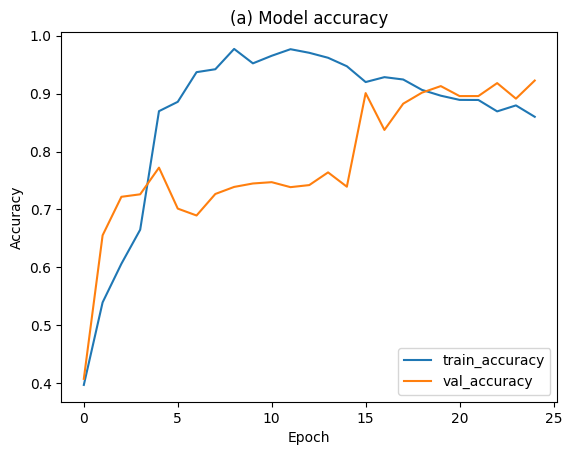

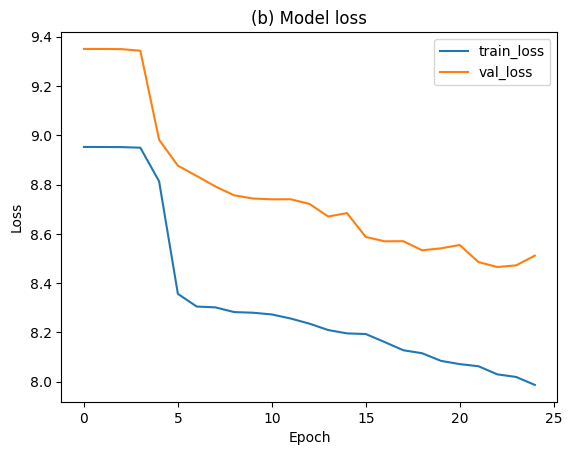

In [12]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.title('(a) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('(b) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Prediction

In [26]:
# prediction on test dataset is useful test our model on a new unkown dataset
preds_test = model.predict(test_data, verbose=1)

# let's consider only prediction values higher than 60%
preds_test_t = (preds_test > 0.6).astype(np.uint8)

35/35 [==============================] - 2s 63ms/step


In [27]:
# --> PredictionCheck: function that takes in input a random train data slice 
#                      and plot it in comparison with the corresponding known
#                      segmentation and predicted segmentation
def PredictionCheck(train_img, train_label, preds_train_t):
    # random index for choosing image
    ix = random.randint(0, len(preds_train_t))

    # I want 3 subplots
    fig, ax = plt.subplots(1, 3,figsize=(15,5))

    # 1st subplot: original slice in greyscale
    ax[0].imshow(train_img[ix])
    ax[0].set_title("original layer: " + str(ix) )

    # 2nd subplot: given related segmentation in greyscale
    ax[1].imshow(train_label[ix])
    ax[1].set_title("mask layer: " + str(ix) )

    # 3rd subplot: predicted segmentation in greyscale
    ax[2].imshow(preds_train_t[ix][:, :, 0])
    ax[2].set_title("preds layer: " + str(ix) )

    plt.show()

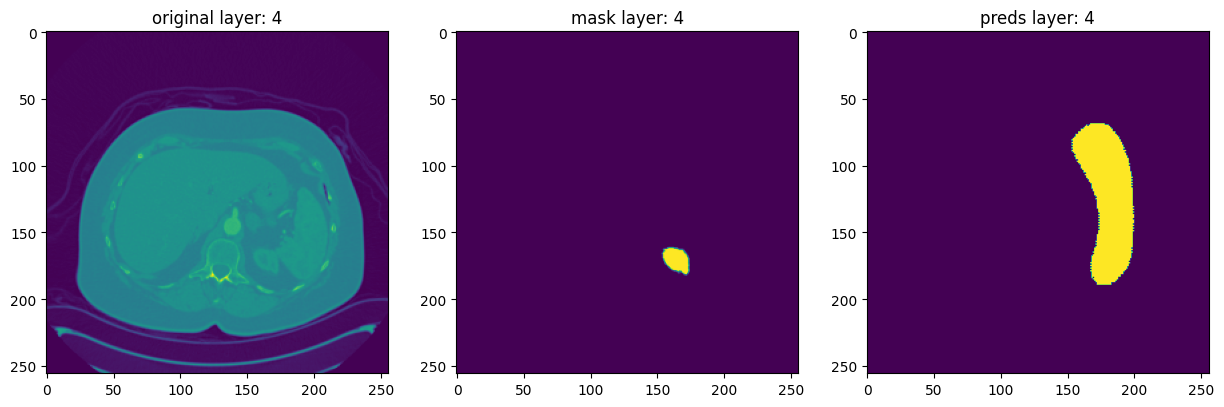

In [44]:
# Prediction of a random test data slice 
# and comparison between volume, segmentation and predicted segmentation
PredictionCheck(test_data, test_label, preds_test_t)